Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.



### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [3]:
# Устанавливаю spacy. Заметил, что она устанавливается без ошибок со второго раза.
import sys
!{sys.executable} -m pip install spacy;
!{sys.executable} -m spacy download en;

  Using cached spacy-2.2.4-cp37-cp37m-manylinux1_x86_64.whl (10.6 MB)
  Using cached wasabi-0.6.0-py3-none-any.whl (20 kB)
  Using cached srsly-1.0.2-cp37-cp37m-manylinux1_x86_64.whl (185 kB)
  Using cached blis-0.4.1-cp37-cp37m-manylinux1_x86_64.whl (3.7 MB)
  Using cached catalogue-1.0.0-py2.py3-none-any.whl (7.7 kB)
  Using cached thinc-7.4.0-cp37-cp37m-manylinux1_x86_64.whl (2.2 MB)
     |████████████████████████████████| 12.0 MB 198 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011737 sha256=d6de406389813794610e06099308a6e5a526bc442fd2d9484335542c6afd5092
  Stored in directory: /tmp/pip-ephem-wheel-cache-0f5r1p4i/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-pack

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
import re
import spacy
from tqdm import notebook
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,make_scorer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import torch
import transformers
from tqdm import notebook
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

ModuleNotFoundError: No module named 'spacy'

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [2]:
df=pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.to_csv('toxic_comments.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В представленном датасете 159571 строк и 2 столбца. Текст сырой, его необходимо будет очистить и ламметизировать. Пропущенных значений нет. Целевым признаком является ['toxic']-оценка токсичности в комментарии ['text']

Text(0.5, 1.0, 'Распределение биноминальных значений при дисбалансе')

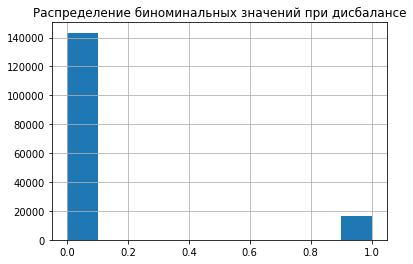

In [9]:
# Смотрю как распределен целевой признак
df['toxic'].hist()
plt.title('Распределение биноминальных значений при дисбалансе')

Присутствует сильный дисбаланс

In [10]:
# функция upsample для создания сбалансированности выборки 
def upsample(features, target, repeat): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [11]:
# Разделяю на признаки и целевой признак
#features=df['text']
#target=df['toxic']

In [12]:
# Разделяю на обучающую и тестовую
#features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.3,random_state=42)

In [13]:
# Применяю функцию upsample
#features_up,target_up=upsample(features_train,target_train,repeat=6)

Как видно, дисбаланс уменьшился. Можно еще улучшить, но чтобы сильно не увеличивать выборку оставлю так.

In [14]:
# объявляю модель spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

In [15]:
# Разделяю на признаки и целевой признак
features=df['text']
target=df['toxic']

In [16]:
# Функция для лемматизации и очистки комментариев
def lemma_by_spacy_clear(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
    #doc=" ".join(doc.lemma_)
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())


In [17]:
# Чищу и ламматизирую обучающую выборку. Примерно 12 мин выполняется
#corpus_lemma=features_train.apply(lemma_by_spacy_clear)

In [18]:
# Чищу и ламматизирую обучающую выборку. Примерно 12 мин выполняется
corpus_lemma=features.apply(lemma_by_spacy_clear)

In [19]:
# Разделяю на обучающую и тестовую
features_train,features_test,target_train,target_test=train_test_split(corpus_lemma,target,test_size=0.3,random_state=42)

In [20]:
# Применяю функцию upsample
features_up,target_up=upsample(features_train,target_train,repeat=6)

Text(0.5, 1.0, 'Распределение биноминальных значений сбалансированности')

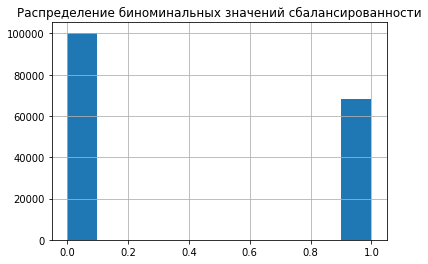

In [21]:
target_up.hist()
plt.title('Распределение биноминальных значений сбалансированности')

Text(0.5, 1.0, 'Распределение биноминальных значений для теста (без балансировки)')

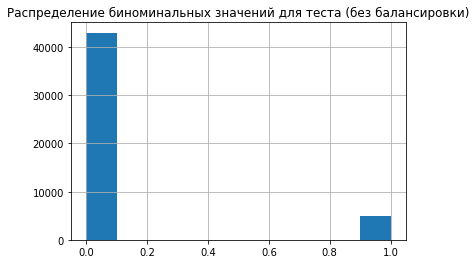

In [22]:
target_test.hist()
plt.title('Распределение биноминальных значений для теста (без балансировки)')

In [23]:
# # Чищу и ламматизирую тестовую выборку. Примерно 7 мин выполняется
#corpus_lemma_test=features_test.apply(lemma_by_spacy_clear)

In [24]:
#corpus_lemma

In [25]:
nltk.download('stopwords')# загружаю стоп слова
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # Объявляю счетчик

In [27]:
#courpus_tfid_train=count_tf_idf.fit_transform(corpus_lemma)#Считаю Tf-idf для обучающей
#courpus_tfid_test=count_tf_idf.transform(corpus_lemma_test)#Считаю Tf-idf для тестовой

In [28]:
##!!! Перевожу в векторный вид обучающую и тестовую
courpus_tfid_train=count_tf_idf.fit_transform(features_up)#Считаю Tf-idf для обучающей
courpus_tfid_test=count_tf_idf.transform(features_test)#Считаю Tf-idf для тестовой

# 2. Обучение

### model LogisticRegression

In [29]:
features_train=courpus_tfid_train
target_train=target_up

In [30]:
features_test=courpus_tfid_test
target_test=target_test

In [31]:
## Подбираю лучший гиперпараметр
model_log=LogisticRegression(n_jobs=-1, random_state=7).fit(features_train,target_train)

print("f1 для теста до подбора гиперпараметров:",f1_score(model_log.predict(features_test),target_test))


from sklearn.model_selection import GridSearchCV

param_grid= [
    {'C': [2,4,5,6],#np.logspace(-5, 0, 8),
     'n_jobs': [-1,1]},
    {'C': np.logspace(-5, 0, 8)}
]
grid_model_reg = GridSearchCV(model_log, param_grid, cv=3, n_jobs=-1,scoring='f1')

grid_model_reg.fit(features_train, target_train)
# Печать настроенных параметров и оценка

print("Tuned Logistic Regression Parameters: {}".format(grid_model_reg.best_params_)) 

print("Best F1 score is {}".format(grid_model_reg.best_score_))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1 для теста до подбора гиперпараметров: 0.7665505226480837


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Tuned Logistic Regression Parameters: {'C': 6, 'n_jobs': -1}
Best F1 score is 0.9648046623290218


In [32]:
#model_line=LogisticRegression().fit(courpus_tfid_train,target_up)
model_log_cv=LogisticRegression(n_jobs=-1,C=7, class_weight='balanced',random_state=7).fit(features_train,target_train)

In [33]:
f1_line=f1_score(model_log_cv.predict(features_test),target_test)

In [58]:
print("f1:",round(f1_line,2))


f1: 0.76


Подобрал параметр регуляризации С при помощи GridSearchCV выше. Теперь как я поимаю все честно сделал. Переобучение конечно присутствует, но уже гораздо лучше.

### model sklearn.tree.DecisionTreeClassifier

In [35]:
## Подбор лучших гиперпараметров

model_tree=DecisionTreeClassifier(max_depth=2,random_state=42).fit(features_train,target_train)

print("f1 для теста до подбора гиперпараметров:",f1_score(model_tree.predict(features_test),target_test))

      
param_grid={"max_depth": [2,4,6,8,10],'class_weight':['balanced']}
    

      
grid_param_model_tree=GridSearchCV(model_tree,param_grid,cv=3,n_jobs=-1,scoring='f1') 

grid_param_model_tree.fit(features_train, target_train)
# Печать настроенных параметров и оценка

print("Tuned Logistic Regression Parameters: {}".format(grid_param_model_tree.best_params_)) 

print("Best f1 score is {}".format(grid_param_model_tree.best_score_))

f1 для теста до подбора гиперпараметров: 0.3823189840013195
Tuned Logistic Regression Parameters: {'class_weight': 'balanced', 'max_depth': 2}
Best f1 score is 0.6130855630748765


In [36]:
#model_line=LogisticRegression().fit(courpus_tfid_train,target_up)
model_tree_cv=DecisionTreeClassifier(max_depth=10,class_weight='balanced', random_state=42).fit(features_train,target_train)


In [37]:
f1_tree=f1_score(model_tree_cv.predict(features_test),target_test)


In [57]:
print("f1:",round(f1_tree,2 ))


f1: 0.57


Для Деревьев значение F1 хуже и на кросс-валидации и на тестовой по сравнению я логистической регрессией. Но модель меньше переобучена чем на логистической регрессией.

### model RandomForestClassifier

In [91]:
## Подбор лучших гиперпараметров

model_forest=RandomForestClassifier(n_estimators=1,max_depth=2,random_state=42).fit(features_train,target_train)

print("f1 для теста до подбора гиперпараметров:",f1_score(model_tree.predict(features_test),target_test))

      
param_grid={"max_depth": [2,4,6,8,10],
            "n_estimators": [10,20,30,40,50,60,70],
            'class_weight':['balanced']}
    

      
grid_param_model_forest=GridSearchCV(model_forest,param_grid,cv=3,n_jobs=-1,scoring='f1_macro') 

grid_param_model_forest.fit(features_train, target_train)
# Печать настроенных параметров и оценка

print("Tuned Logistic Regression Parameters: {}".format(grid_param_model_forest.best_params_)) 

print("Best f1 score is {}".format(grid_param_model_forest.best_score_))

f1 для теста до подбора гиперпараметров: 0.3823189840013195
accuracy для теста до подбора гиперпараметров: 0.9217705548128342
Tuned Logistic Regression Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 70}
Best score is 0.7405868991102901


In [51]:
model_forest_cv=RandomForestClassifier(n_estimators= 70,max_depth=10,random_state=42).fit(features_train,target_train)


In [52]:
f1_forest=f1_score(model_forest_cv.predict(features_test),target_test)

In [56]:
print("f1:",round(f1_forest,2))

f1: 0.06


### model CatBoostClassifier

In [39]:
model_cat=CatBoostClassifier(loss_function="Logloss", iterations=40)

In [40]:
model_cat.fit(courpus_tfid_train,target_up)

Learning rate set to 0.5
0:	learn: 0.5439938	total: 6.22s	remaining: 4m 2s
1:	learn: 0.4883573	total: 11.4s	remaining: 3m 36s
2:	learn: 0.4608334	total: 16.2s	remaining: 3m 19s
3:	learn: 0.4411778	total: 21.2s	remaining: 3m 10s
4:	learn: 0.4225967	total: 26s	remaining: 3m 2s
5:	learn: 0.4072806	total: 31s	remaining: 2m 55s
6:	learn: 0.3953789	total: 35.9s	remaining: 2m 49s
7:	learn: 0.3854258	total: 40.7s	remaining: 2m 42s
8:	learn: 0.3758334	total: 45.5s	remaining: 2m 36s
9:	learn: 0.3679220	total: 50.3s	remaining: 2m 30s
10:	learn: 0.3615493	total: 55.3s	remaining: 2m 25s
11:	learn: 0.3562138	total: 1m	remaining: 2m 20s
12:	learn: 0.3500305	total: 1m 4s	remaining: 2m 14s
13:	learn: 0.3456425	total: 1m 9s	remaining: 2m 9s
14:	learn: 0.3412046	total: 1m 14s	remaining: 2m 4s
15:	learn: 0.3375150	total: 1m 19s	remaining: 1m 58s
16:	learn: 0.3339078	total: 1m 23s	remaining: 1m 53s
17:	learn: 0.3304726	total: 1m 28s	remaining: 1m 48s
18:	learn: 0.3263621	total: 1m 33s	remaining: 1m 43s
19:

In [41]:
predict_cat=model_cat.predict(courpus_tfid_test)

In [42]:
confusion_matrix(predict_cat,target_test)

array([[41628,  1157],
       [ 1377,  3710]])

In [43]:
f1_cat=round(f1_score(predict_cat,target_test),2)
f1_cat


0.75

### model RuBert

In [43]:
##df=df.sample(n=int(len(df)/10),random_state=42)
##df=df.sample(n=30,random_state=42)
df_features_up=pd.DataFrame(features_up)
df_target_up=pd.DataFrame(target_up)
df_BERT_features=df_features_up.sample(n=50,random_state=42)


In [44]:
df_BERT_target=target_up[df_BERT_features.index]

In [45]:
df_BERT_target = df_BERT_target.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

In [46]:
tokenizer = transformers.BertTokenizer(
    vocab_file='/datasets/ds_bert/vocab.txt')

##tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized = df_BERT_features['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [47]:
max_len

382

In [48]:
config = transformers.BertConfig.from_json_file(
    '/datasets/ds_bert/bert_config.json')
model = transformers.BertModel.from_pretrained(
    '/datasets/ds_bert/rubert_model.bin', config=config)

In [49]:
batch_size = 10
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [50]:
features = np.concatenate(embeddings)

features.shape

(50, 768)

In [51]:
df_BERT_target.shape

(50, 1)

In [52]:
target=df_BERT_target


In [53]:
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.5,random_state=42)

In [54]:
model=LogisticRegression().fit(features_train,target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
predict=model.predict(features_test)
accuracy=accuracy_score(predict,target_test)

In [56]:
confusion_matrix(predict,target_test)

array([[16,  4],
       [ 3,  2]])

In [57]:
f1_line=f1_score(predict,target_test)


0.3636363636363636

# 3. Выводы

In [59]:
razult=np.array([f1_line,f1_tree,f1_forest,f1_cat])

In [60]:
rezult_df=pd.DataFrame(razult,index=['LogisticRegression',"DecisionTreeClassifier",'RandomForestClassifier','CatBoostClassifier'])
rezult_df.set_axis(['F1'],axis='columns',inplace=True)
rezult_df

,F1
LogisticRegression,0.760918
DecisionTreeClassifier,0.572058
RandomForestClassifier,0.058249
CatBoostClassifier,0.750000
